# Data Incubator - Project Idea Update - Feb 16 2015 
author marco.pritoni@gmail.com

In [1]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.plotly as py
import os
from matplotlib import style
import seaborn as sns
sns.set(color_codes=True)
from sklearn import svm, cross_validation, linear_model, preprocessing

style.use('ggplot')

In [2]:
# A modular project:
# Core Project Idea
# Additional Parts
# Timeline


## 1) Gather data from the sample dataset (UCI ML repo)
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
##### note: the source says:
Georges HÃ©brail (georges.hebrail '@' edf.fr), Senior Researcher, EDF R&D, Clamart, France 
Alice BÃ©rard, TELECOM ParisTech Master of Engineering Internship at EDF R&D, Clamart, France
##### from this I guessed the house is located in Clamart, France

In [3]:
house_data=pd.read_csv('../data/household_power_consumption.txt', sep=';',low_memory=False)
print "size of dataset %s rows" %house_data.count()[1]
print house_data.columns
house_data.head()

size of dataset 2075259 rows
Index([u'Date', u'Time', u'Global_active_power', u'Global_reactive_power',
       u'Voltage', u'Global_intensity', u'Sub_metering_1', u'Sub_metering_2',
       u'Sub_metering_3'],
      dtype='object')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17


### Convert types

In [4]:
house_data['act_pow']=pd.to_numeric(house_data['Global_active_power'].dropna(), errors='coerce')

In [5]:
house_data['datetime']=house_data['Date'] + ' ' + house_data['Time']
house_data['datetime']=pd.to_datetime(house_data['datetime'].dropna(), errors='coerce')

In [6]:
house_data['sub_pow1']=pd.to_numeric(house_data['Sub_metering_1'].dropna(), errors='coerce')
house_data['sub_pow2']=pd.to_numeric(house_data['Sub_metering_2'].dropna(), errors='coerce')
house_data['sub_pow3']=pd.to_numeric(house_data['Sub_metering_3'].dropna(), errors='coerce')

### Set date_time Index and group by 1h (1 min timestamp is excessive for this use)

In [7]:
house_data.set_index(house_data['datetime'], inplace=True,drop=True)
house_data_h=house_data.groupby(pd.TimeGrouper('60Min')).mean().interpolate(method='time')#.dropna()
col_keep=["act_pow","sub_pow1","sub_pow2","sub_pow3"]
house_data_h=house_data_h.loc[:,col_keep]
house_data_h.head()

,act_pow,sub_pow1,sub_pow2,sub_pow3
datetime,,,,
2006-12-16 17:00:00,4.222889,0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0,0.416667,17.216667


## 2) Gather weather data 
http://www.ncdc.noaa.gov/cdo-web/datasets
http://www7.ncdc.noaa.gov/CDO/cdopoemain.cmd?datasetabbv=DS3505&countryabbv=&georegionabbv=&resolution=40
#### location Orly (FR)

In [24]:
weather=pd.read_csv('../data/NOAA_weather.txt', delimiter=r"\s+")
print "size of dataset %s rows" %weather.count()[1]
print weather.columns
weather.head()

size of dataset 68111 rows
Index([u'USAF', u'WBAN', u'YR--MODAHRMN', u'DIR', u'SPD', u'GUS', u'CLG',
       u'SKC', u'L', u'M', u'H', u'VSB', u'MW', u'MW.1', u'MW.2', u'MW.3',
       u'AW', u'AW.1', u'AW.2', u'AW.3', u'W', u'TEMP', u'DEWP', u'SLP',
       u'ALT', u'STP', u'MAX', u'MIN', u'PCP01', u'PCP06', u'PCP24', u'PCPXX',
       u'SD'],
      dtype='object')


,USAF,WBAN,YR--MODAHRMN,DIR,SPD,GUS,CLG,SKC,L,M,...,SLP,ALT,STP,MAX,MIN,PCP01,PCP06,PCP24,PCPXX,SD
0,71490,99999,200612160000,210,9,***,***,SCT,0,0,...,1024.2,30.21,1013.0,***,***,*****,0.00,*****,0.00,**
1,71490,99999,200612160030,210,7,***,***,***,*,*,...,******,30.21,******,***,***,*****,*****,*****,*****,**
2,71490,99999,200612160100,190,7,***,***,SCT,0,0,...,1024.0,30.21,1012.8,***,***,0.00,*****,*****,*****,**
3,71490,99999,200612160130,180,7,***,***,***,*,*,...,******,30.21,******,***,***,*****,*****,*****,*****,**
4,71490,99999,200612160200,170,9,***,246,BKN,0,0,...,1023.8,30.21,1012.6,***,***,0.00,*****,*****,*****,**


### Convert types

In [9]:
weather['TEMP']=pd.to_numeric(weather['TEMP'].dropna(), errors='coerce')
h=weather['YR--MODAHRMN'].astype(str).str[8:10]
m=weather['YR--MODAHRMN'].astype(str).str[10:12]
time=' '+h+':'+m
dateTime=weather['YR--MODAHRMN'].astype(str).str[:8] +time
weather["datetime"]=pd.to_datetime(dateTime)

### Set date_time Index and group by 1h

In [10]:
weather.set_index(weather['datetime'], inplace=True)
weather_h=weather.groupby(pd.TimeGrouper('60Min')).mean().interpolate(method='time')#.dropna()
col_keep=["TEMP"]
weather_h=weather_h.loc[:,col_keep]
weather_h.head()

,TEMP
datetime,
2006-12-16 00:00:00,41.5
2006-12-16 01:00:00,39.5
2006-12-16 02:00:00,39.0
2006-12-16 03:00:00,38.5
2006-12-16 04:00:00,39.5


## 3) Merge Datasets

In [11]:
merged=house_data_h.join(weather_h)
print "size of dataset %s rows" %merged.count()[1]
merged["TOD"]=merged.index.hour
merged["DOW"]=merged.index.weekday
merged["WEEK"]=merged.index.week
merged["MONTH"]=merged.index.month
merged.head()

size of dataset 34951 rows


,act_pow,sub_pow1,sub_pow2,sub_pow3,TEMP,TOD,DOW,WEEK,MONTH
datetime,,,,,,,,,
2006-12-16 17:00:00,4.222889,0,0.527778,16.861111,44.5,17,5,50,12
2006-12-16 18:00:00,3.632200,0,6.716667,16.866667,44.5,18,5,50,12
2006-12-16 19:00:00,3.400233,0,1.433333,16.683333,42.0,19,5,50,12
2006-12-16 20:00:00,3.268567,0,0.000000,16.783333,38.5,20,5,50,12
2006-12-16 21:00:00,3.056467,0,0.416667,17.216667,36.5,21,5,50,12


## 4) Data Exploration

### Plot data at 1h resolution

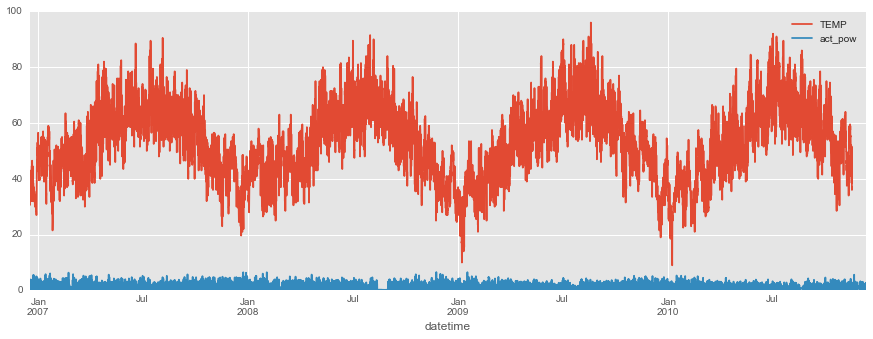

In [12]:
merged['act_pow50']=merged['act_pow']*50
merged[['TEMP','act_pow']].plot(figsize=(15,5))

### Plot data at 1d resolution (power rescaled)

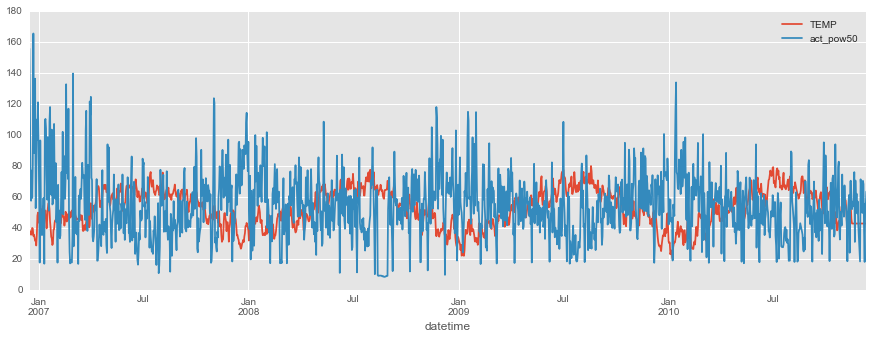

In [13]:
daily=merged.groupby(pd.TimeGrouper('d')).mean().interpolate(method='time').dropna()
daily['act_pow50']=daily['act_pow']*50 # to quickly show trends without second axis
daily[["TEMP","act_pow50"]].plot(figsize=(15,5))

### Plot data at 1 month resolution (power rescaled)

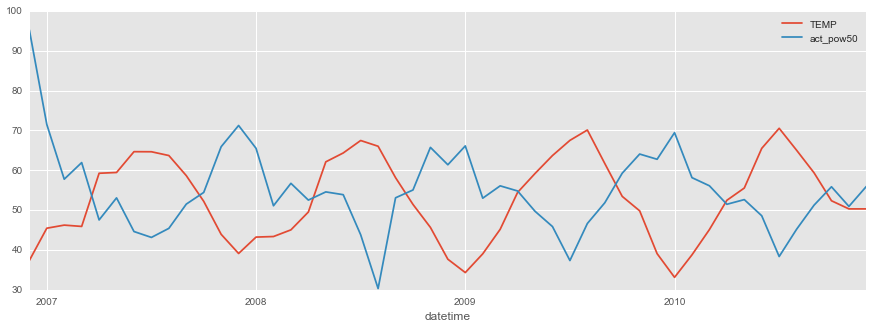

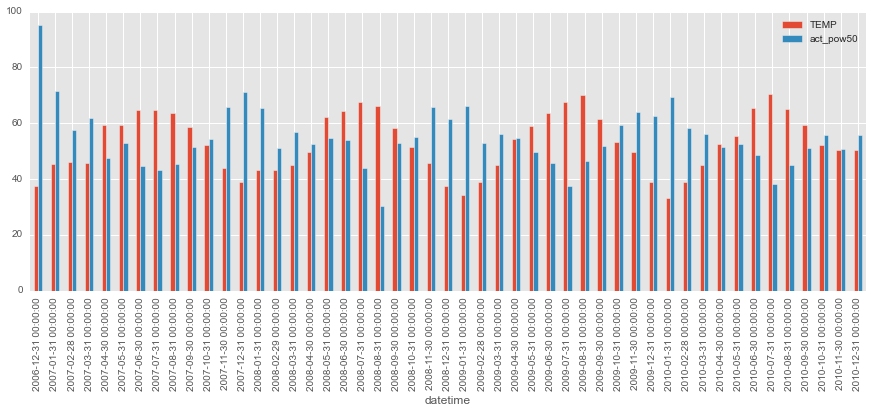

In [14]:
monthly=merged.groupby(pd.TimeGrouper('M')).mean().interpolate(method='time').dropna()
monthly['act_pow50']=monthly['act_pow']*50 # to quickly show trends without second axis
monthly[["TEMP","act_pow50"]].plot(figsize=(15,5) )
monthly[["TEMP","act_pow50"]].plot(figsize=(15,5),kind='bar' )

### Explore TEMP dependence

### Monthly Scatter Plot (very clear seasonal trend: electric heating)

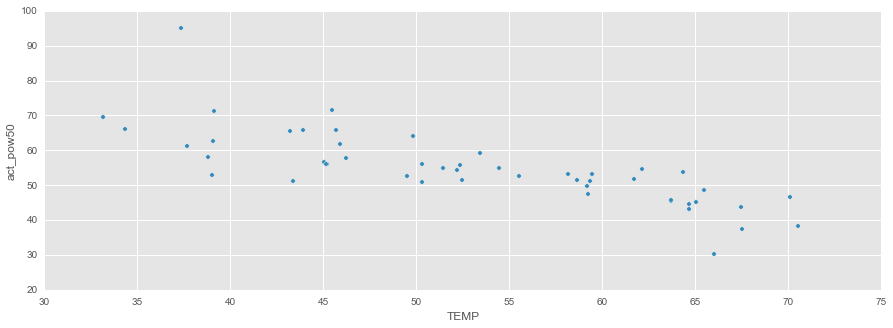

In [25]:
monthly.plot(figsize=(15,5),kind='scatter',y="act_pow50",x="TEMP" )

### Daily Scatter Plot (messier trend)

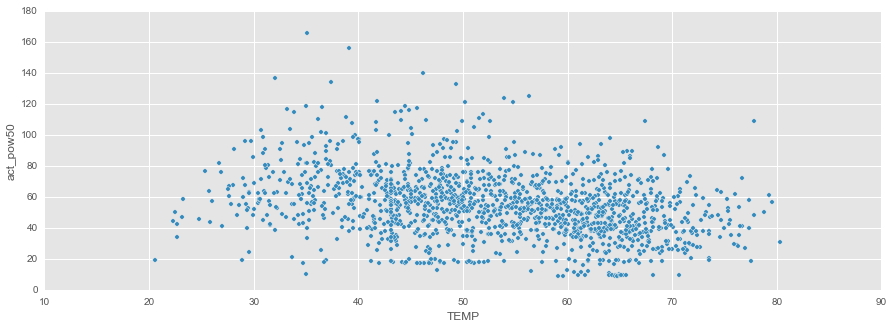

In [16]:
daily.plot(figsize=(15,5),kind='scatter',y="act_pow50",x="TEMP" )

### Hourly Scatter Plot of sub_meter3: heating/AC (even messier)

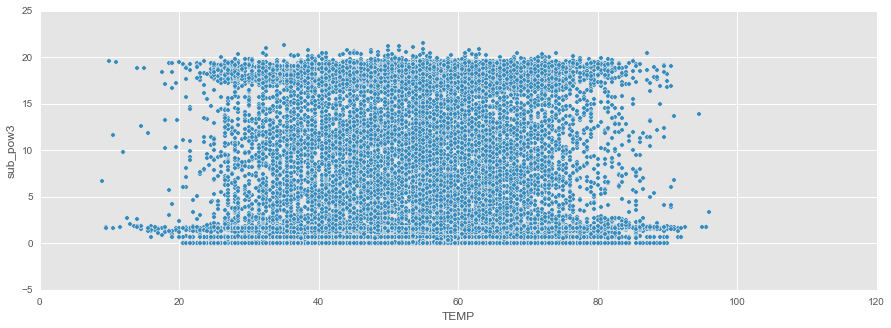

In [17]:
merged.plot(figsize=(15,5),kind='scatter',y="sub_pow3",x="TEMP")

### What? There seem to be less-temperature dependence here. How is is possible? This is the heating submeter...

### Let's see if the amount of point in the graph is misleading:

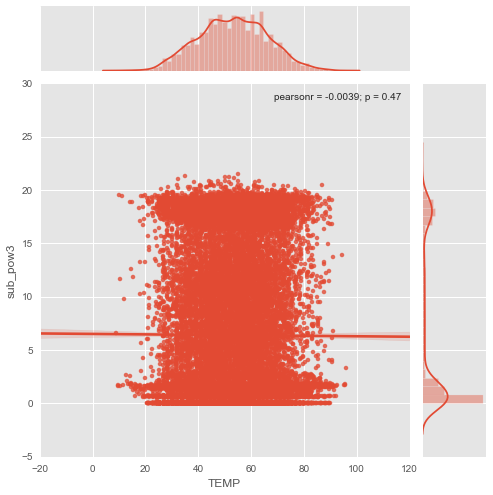

In [18]:
sns.jointplot(x="TEMP", y="sub_pow3", data=merged, size=7,kind="reg")

### Yes it is. There are very few points in the middle.
### Clear bi-modal distribution. The power values are mostly around 0 (off) and a sometimes ~15-20 (on)
### Still the correlation with outdoor temp looks small
### Let's see if the heater is on a timer (on-off at certain times)

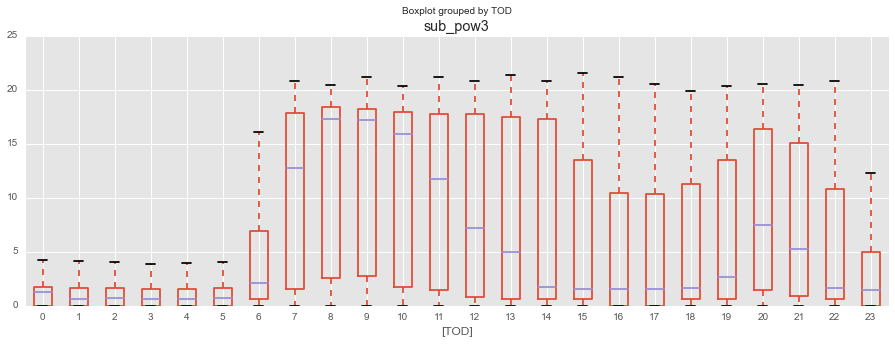

In [19]:
new_table=merged[['sub_pow3','TOD']]
new_table.reset_index().boxplot(by='TOD', figsize = (15,5))

### Yes it is !! Now only plotting time of day between 7am-10pm

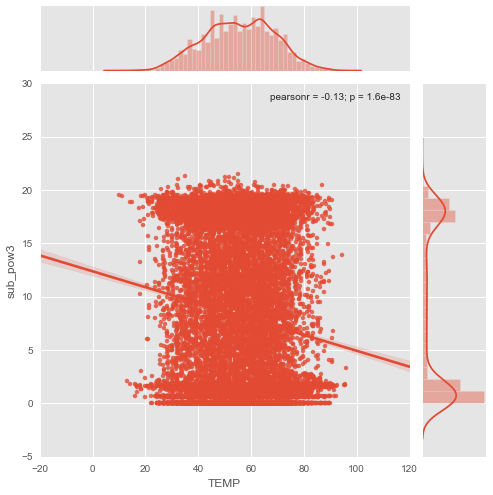

In [20]:
cut=merged[(merged["TOD"]>6) & (merged["TOD"]<23)]
sns.jointplot(x="TEMP", y="sub_pow3", data=cut, size=7,kind="reg")

## 5) Develop simple Energy Prediction Model (proof of concept)

### Split DataSet in Training and Validation

In [21]:
data_train=monthly.loc["2006-12-31":"2009-12-31",["TEMP","MONTH"]]
target_train=monthly.loc["2006-12-31":"2009-12-31","act_pow"]
data_val=monthly.loc["2010-01-31":"2010-12-31",["TEMP","MONTH"]]
target_val=monthly.loc["2010-01-31":"2010-12-31","act_pow"]

### Train a simple linear model

In [22]:
clf = linear_model.LinearRegression()
model=clf.fit(data_train,target_train)

### Predict Energy Use in the validation period

R^2 in validation 0.674397275973 


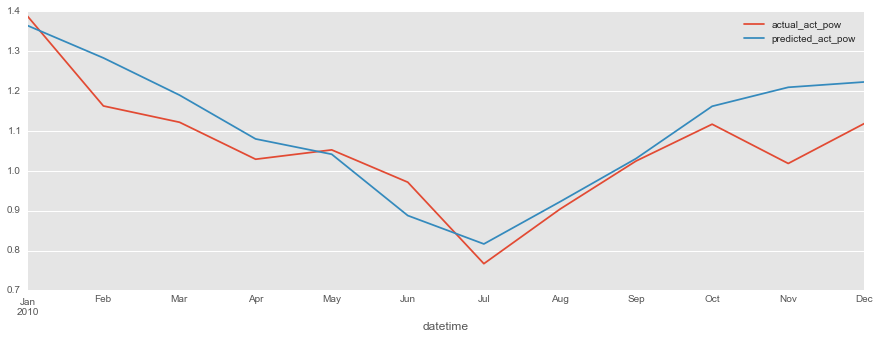

In [23]:
compare=pd.DataFrame(target_val)
compare.columns=["actual_act_pow"]
compare["predicted_act_pow"]=model.predict(data_val)

print "R^2 in validation %s " % clf.fit(data_train,target_train).score(data_val,target_val)
compare.plot(figsize=(15,5))

## 6) Future Work (possible interesting directions)

### A) same dataset:
        a) improve the model with additional variables (holidays, events in calendar, other weather info), other ML algorithms
        b) create a daily model with more variables (WE/WD ...)
        c) explore energy disaggregation tech at higher resolution
        d) test daily energy predictions (simulate each day going by with real energy data and weather forecast. See if prediction are correct)
        e) download electricity cost and combine it with energy use
        f) try to connect to API, instead of downloading
### B) test other datasets just found and see how they compare:
        a) http://blog.oliverparson.co.uk/2012/06/public-data-sets-for-nialm.html
        b) in California Smart Meter Data is downloadable via green button (there is an API)